# Improved DeepONet Training for Aeroelasticity (Round 4)

This notebook implements the refined training pipeline for the Spectral DeepONet, incorporating feedback from multiple critical reviews.

## Methodology
1.  **Physics-Based Inputs:** 
    - Branch Net Inputs: $\alpha_{apex}$ (Shape), $Re$ (Reynolds Number), $\sin(\alpha_0)$, $\cos(\alpha_0)$ (Angle of Attack).
    - Trunk Net Input: Affine-scaled Strouhal number $St \in [-1, 1]$.
2.  **Spectral Representation:** 
    - Target: $\log_{10}(PSD)$ on a linear Strouhal grid ($St \in [0.05, 5.0]$).
3.  **Peak-Weighted Loss:** 
    - To improve peak frequency prediction, the MSE loss is weighted to emphasize the region around the true peak:
    $$ w(St) = 1 + 10 \cdot \exp\left(-\frac{(St - St_{peak})^2}{2(0.1)^2}\right) $$
4.  **Robust Evaluation:** 
    - 5-Fold Cross-Validation.
    - Outlier Analysis.

> [!IMPORTANT]
> **Validity Domain**: This model is trained for Isosceles Triangles with:
> - $H/D \in \{1/3, 1/2, 2/3\}$
> - $Re_D \in [1.5 \times 10^6, 6.45 \times 10^6]$
> - $AoA \in [55^\circ, 125^\circ]$
> Predictions outside this range are extrapolations and should be treated with caution.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
from scipy.fft import fft, fftfreq
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Configuration
DATA_DIR = "processed_data"
CHECKPOINT_DIR = "checkpoints_improved"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f"Using device: {DEVICE}")

# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
EPOCHS = 1000
N_FREQ_SAMPLES = 1000  # Number of frequencies to sample per case per epoch
PEAK_WINDOW = 0.1      # Window around peak (fraction of frequency range or absolute Hz)
PEAK_RATIO = 0.6       # Fraction of samples to take from peak region

Using device: mps


## 1. Data Loading and Processing

In [2]:
class AeroDataLoader:
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        self.npz_path = self.data_dir / "improved_ml_dataset.npz"
        self.h5_path = self.data_dir / "improved_psd_dataset.h5"
        
    def load_data(self):
        # Load summary features and normalization stats
        data = np.load(self.npz_path, allow_pickle=True)
        self.X = data['X']  # [alpha_apex, Re, sin_alpha0, cos_alpha0]
        self.y = data['y']
        self.case_ids = data['case_ids']
        self.feature_names = data['feature_names']
        
        # Load normalization stats
        self.X_mean = data['X_mean']
        self.X_std = data['X_std']
        
        # Load spectral data (Log-PSD on Linear Strouhal grid)
        self.spectral_data = {}
        
        with h5py.File(self.h5_path, 'r') as f:
            for i, case_id in enumerate(self.case_ids):
                if case_id not in f:
                    continue
                    
                grp = f[case_id]
                
                # Load Strouhal grid and Log-PSD
                st_grid = grp['st_grid'][:]
                log_psd = grp['log_psd'][:]
                
                # Get design params for this case
                design_params = self.X[i]
                
                # Normalize design params
                design_params_norm = (design_params - self.X_mean) / self.X_std
                
                self.spectral_data[case_id] = {
                    'design_params': design_params_norm, # Normalized
                    'design_params_raw': design_params,  # Original for reference
                    'st_grid': st_grid,
                    'log_psd': log_psd
                }
                
        print(f"Loaded {len(self.spectral_data)} cases.")
        return self.spectral_data


## 2. Improved Dataset with Importance Sampling

In [3]:
class ImprovedAeroDataset(Dataset):
    def __init__(self, spectral_data):
        """
        Args:
            spectral_data: Dict of case data
        """
        self.data = list(spectral_data.values())
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        case = self.data[idx]
        design_params = case['design_params'] # Normalized [alpha_apex, Re, sin_alpha0, cos_alpha0]
        st_grid = case['st_grid']
        log_psd = case['log_psd']
        
        # Find True Peak Strouhal
        peak_idx = np.argmax(log_psd)
        st_peak = st_grid[peak_idx]
        
        n_points = len(st_grid)
        
        # Prepare tensors
        branch_in = np.tile(design_params, (n_points, 1))
        
        # Affine Scaling for Trunk Input
        trunk_in = ((st_grid - 2.5) / 2.5).reshape(-1, 1)
        
        target = log_psd.reshape(-1, 1)
        
        # Compute Peak-Focused Weights
        # w = 1 + alpha * exp( - (St - St_peak)^2 / (2 * sigma^2) )
        alpha = 10.0
        sigma = 0.1
        
        weights = 1.0 + alpha * np.exp( - (st_grid - st_peak)**2 / (2 * sigma**2) )
        weights = weights.reshape(-1, 1)
        
        return (
            torch.FloatTensor(branch_in),
            torch.FloatTensor(trunk_in),
            torch.FloatTensor(target),
            torch.FloatTensor(weights)
        )


## 3. DeepONet Model

In [4]:
class DeepONet(nn.Module):
    def __init__(self, branch_dim=4, trunk_dim=1, hidden_dim=64, latent_dim=64):
        super().__init__()
        
        # Simplified Branch Net (3 layers)
        self.branch = nn.Sequential(
            nn.Linear(branch_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim)
        )
        
        # Simplified Trunk Net (3 layers)
        self.trunk = nn.Sequential(
            nn.Linear(trunk_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim)
        )
        
        # Bias
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, x_branch, x_trunk):
        # x_branch: [batch, branch_dim]
        # x_trunk: [batch, trunk_dim]
        
        b_out = self.branch(x_branch)
        t_out = self.trunk(x_trunk)
        
        # Dot product
        # sum(b * t, dim=1)
        out = torch.sum(b_out * t_out, dim=1, keepdim=True) + self.bias
        return out


## 4. Training Loop

In [5]:
from sklearn.model_selection import KFold

def train_model_cv(n_splits=5):
    # Reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Load Data
    loader = AeroDataLoader(DATA_DIR)
    spectral_data = loader.load_data()
    case_ids = np.array(list(spectral_data.keys()))
    
    # K-Fold CV
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_results = []
    fold_histories = [] # Store loss history
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(case_ids)):
        print(f"\n--- Fold {fold+1}/{n_splits} ---")
        
        train_ids = case_ids[train_idx]
        val_ids = case_ids[val_idx]
        
        train_data = {k: spectral_data[k] for k in train_ids}
        val_data = {k: spectral_data[k] for k in val_ids}
        
        train_dataset = ImprovedAeroDataset(train_data)
        val_dataset = ImprovedAeroDataset(val_data)
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        # Model
        model = DeepONet(branch_dim=4).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        
        # Training Loop
        best_val_loss = float('inf')
        patience = 50
        patience_counter = 0
        history = {'train_loss': [], 'val_loss': []}
        
        for epoch in range(EPOCHS):
            model.train()
            total_loss = 0
            
            for branch_in, trunk_in, target, weights in train_loader:
                branch_in = branch_in.view(-1, 4).to(DEVICE)
                trunk_in = trunk_in.view(-1, 1).to(DEVICE)
                target = target.view(-1, 1).to(DEVICE)
                weights = weights.view(-1, 1).to(DEVICE)
                
                optimizer.zero_grad()
                pred = model(branch_in, trunk_in)
                
                # Weighted MSE
                loss = torch.mean(weights * (pred - target)**2)
                
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                
            avg_train_loss = total_loss / len(train_loader)
            history['train_loss'].append(avg_train_loss)
            
            # Validation
            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for branch_in, trunk_in, target, weights in val_loader:
                    branch_in = branch_in.view(-1, 4).to(DEVICE)
                    trunk_in = trunk_in.view(-1, 1).to(DEVICE)
                    target = target.view(-1, 1).to(DEVICE)
                    weights = weights.view(-1, 1).to(DEVICE)
                    
                    pred = model(branch_in, trunk_in)
                    loss = torch.mean(weights * (pred - target)**2)
                    total_val_loss += loss.item()
                    
            avg_val_loss = total_val_loss / len(val_loader)
            history['val_loss'].append(avg_val_loss)
            
            # Early Stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"deeponet_fold{fold}.pth"))
                patience_counter = 0
            else:
                patience_counter += 1
                
            if (epoch + 1) % 50 == 0:
                print(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.6f}")
                
        # Load best model for this fold
        model.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, f"deeponet_fold{fold}.pth")))
        
        # Evaluate Fold
        r2, mse, peak_err, rms_err = calculate_metrics(model, val_dataset, DEVICE)
        fold_results.append({
            'r2': np.mean(r2),
            'mse': np.mean(mse),
            'peak_err': np.mean(peak_err),
            'rms_err': np.mean(rms_err),
            'r2_all': r2,
            'case_ids': val_ids
        })
        fold_histories.append(history)
        print(f"Fold {fold+1} Results: R2={np.mean(r2):.4f}, PeakErr={np.mean(peak_err)*100:.2f}%")
        
    return fold_results, fold_histories, spectral_data


## 5. Verification / Visualization

Loaded 75 cases.

--- Fold 1/5 ---
Epoch 50, Val Loss: 4.940083
Epoch 100, Val Loss: 4.363801
Epoch 150, Val Loss: 4.089267
Epoch 200, Val Loss: 4.044548
Epoch 250, Val Loss: 4.290783
Epoch 300, Val Loss: 4.375534
Epoch 350, Val Loss: 4.247104
Epoch 400, Val Loss: 4.201289
Epoch 450, Val Loss: 4.144622
Epoch 500, Val Loss: 4.008611
Epoch 550, Val Loss: 3.888008
Epoch 600, Val Loss: 3.852149
Epoch 650, Val Loss: 3.755705
Epoch 700, Val Loss: 3.712725
Epoch 750, Val Loss: 3.860091
Epoch 800, Val Loss: 3.577351
Epoch 850, Val Loss: 3.399900
Epoch 900, Val Loss: 3.436853
Epoch 950, Val Loss: 3.495908
Epoch 1000, Val Loss: 3.298879
Fold 1 Results: R2=0.4797, PeakErr=48.85%

--- Fold 2/5 ---
Epoch 50, Val Loss: 1.508462
Epoch 100, Val Loss: 1.485513
Epoch 150, Val Loss: 1.323207
Epoch 200, Val Loss: 1.057370
Epoch 250, Val Loss: 0.956222
Epoch 300, Val Loss: 0.957676
Epoch 350, Val Loss: 0.907372
Epoch 400, Val Loss: 1.043161
Epoch 450, Val Loss: 1.230079
Epoch 500, Val Loss: 1.508156
Epoch 

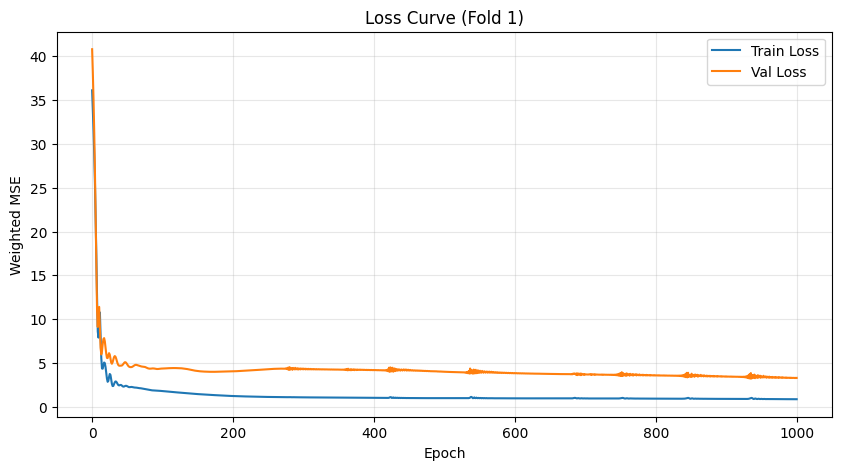


=== Cross-Validation Results ===
Mean R2: 0.6708 +/- 0.1167
Mean Peak St Error: 57.01%


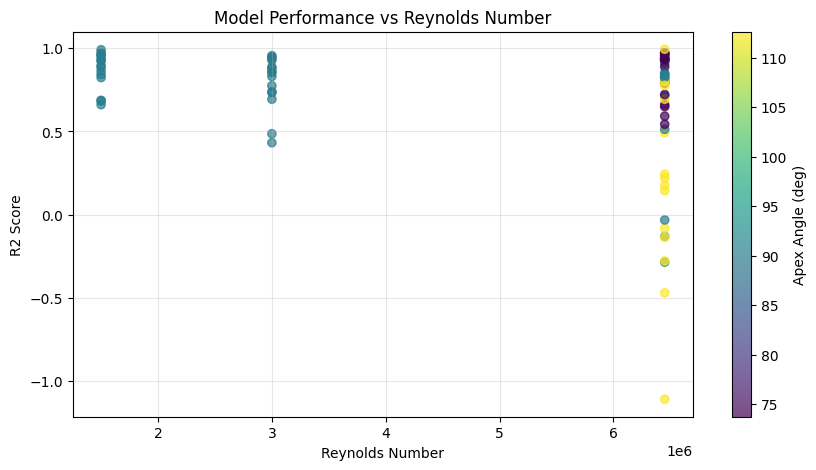

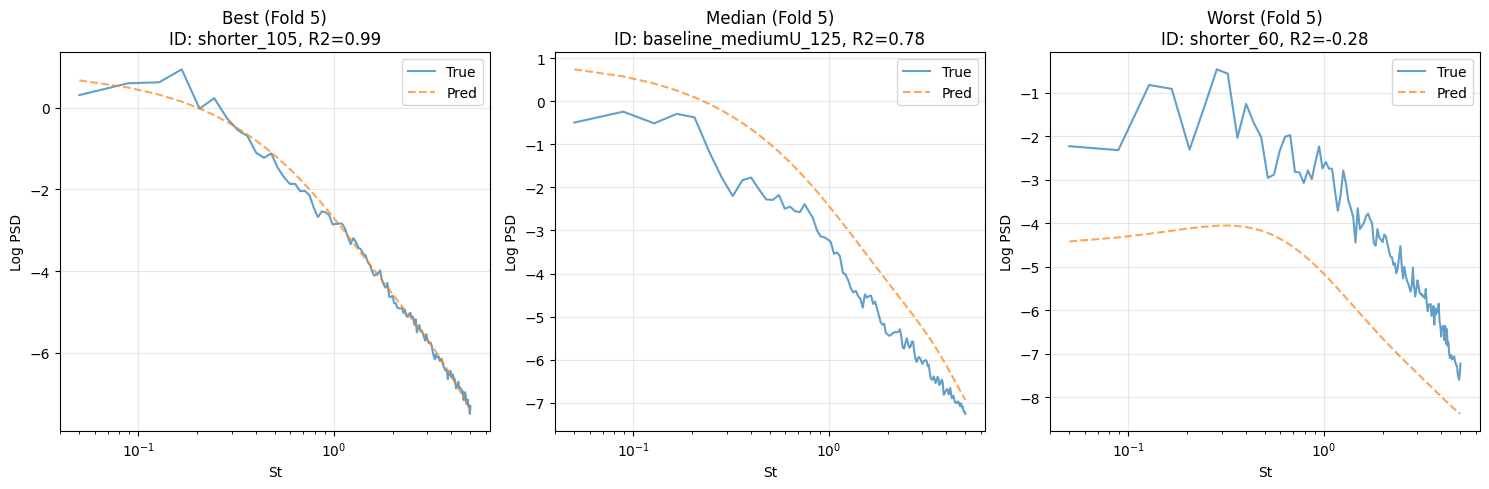

In [6]:
if __name__ == "__main__":
    
    # Helper metrics function
    def calculate_metrics(model, dataset, device):
        """Calculate R2, MSE, Peak St Error, and RMS Error"""
        model.eval()
        r2_scores = []
        mse_scores = []
        peak_st_errors = []
        rms_errors = []
        
        with torch.no_grad():
            for i in range(len(dataset)):
                case = dataset.data[i]
                design_params = case['design_params']
                st_grid = case['st_grid']
                log_psd = case['log_psd']
                
                n_points = len(st_grid)
                branch_in = np.tile(design_params, (n_points, 1))
                trunk_in = ((st_grid - 2.5) / 2.5).reshape(-1, 1) # Affine Scaling
                
                branch_tensor = torch.FloatTensor(branch_in).to(device)
                trunk_tensor = torch.FloatTensor(trunk_in).to(device)
                
                pred = model(branch_tensor, trunk_tensor).cpu().numpy().flatten()
                
                mse = np.mean((pred - log_psd)**2)
                ss_res = np.sum((log_psd - pred)**2)
                ss_tot = np.sum((log_psd - np.mean(log_psd))**2)
                r2 = 1 - ss_res / (ss_tot + 1e-8)
                
                peak_idx_true = np.argmax(log_psd)
                peak_idx_pred = np.argmax(pred)
                st_peak_true = st_grid[peak_idx_true]
                st_peak_pred = st_grid[peak_idx_pred]
                peak_error = np.abs(st_peak_pred - st_peak_true) / st_peak_true
                
                rms_true = np.sqrt(np.mean(log_psd**2))
                rms_pred = np.sqrt(np.mean(pred**2))
                rms_error = np.abs(rms_pred - rms_true) / rms_true
                
                r2_scores.append(r2)
                mse_scores.append(mse)
                peak_st_errors.append(peak_error)
                rms_errors.append(rms_error)
                
        return np.array(r2_scores), np.array(mse_scores), np.array(peak_st_errors), np.array(rms_errors)

    # Run CV
    results, histories, spectral_data = train_model_cv(n_splits=5)
    
    # --- Visualization ---
    
    # 1. Loss Curves (First Fold)
    plt.figure(figsize=(10, 5))
    plt.plot(histories[0]['train_loss'], label='Train Loss')
    plt.plot(histories[0]['val_loss'], label='Val Loss')
    plt.title('Loss Curve (Fold 1)')
    plt.xlabel('Epoch')
    plt.ylabel('Weighted MSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Aggregate Results
    avg_r2 = np.mean([r['r2'] for r in results])
    std_r2 = np.std([r['r2'] for r in results])
    avg_peak = np.mean([r['peak_err'] for r in results])
    
    print(f"\n=== Cross-Validation Results ===")
    print(f"Mean R2: {avg_r2:.4f} +/- {std_r2:.4f}")
    print(f"Mean Peak St Error: {avg_peak*100:.2f}%")
    
    # 2. Outlier Analysis & Scatter Plots
    all_r2 = []
    all_ids = []
    all_re = []
    all_apex = []
    
    for r in results:
        all_r2.extend(r['r2_all'])
        all_ids.extend(r['case_ids'])
        # Get metadata for plotting
        for cid in r['case_ids']:
            meta = spectral_data[cid]['design_params_raw']
            all_apex.append(np.degrees(meta[0]))
            all_re.append(meta[1])
            
    all_r2 = np.array(all_r2)
    all_ids = np.array(all_ids)
    all_re = np.array(all_re)
    all_apex = np.array(all_apex)
    
    # Scatter Plot: R2 vs Re
    plt.figure(figsize=(10, 5))
    plt.scatter(all_re, all_r2, c=all_apex, cmap='viridis', alpha=0.7)
    plt.colorbar(label='Apex Angle (deg)')
    plt.xlabel('Reynolds Number')
    plt.ylabel('R2 Score')
    plt.title('Model Performance vs Reynolds Number')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 3. Plot Best, Median, Worst Cases (from all folds)
    sorted_idx = np.argsort(all_r2)
    best_idx = sorted_idx[-1]
    median_idx = sorted_idx[len(sorted_idx)//2]
    worst_idx = sorted_idx[0]
    
    cases_to_plot = [
        (best_idx, "Best"),
        (median_idx, "Median"),
        (worst_idx, "Worst")
    ]
    
    # We need a model to predict. We'll load the model from the fold that contained the case.
    # But for simplicity, let's just reload the model from Fold 0 and plot a case from Fold 0?
    # No, that's wrong.
    # Let's just reload the model corresponding to the case's fold.
    # We didn't track which fold each case belongs to in the flat list.
    # Let's just plot using the LAST trained model (Fold 5) and pick cases FROM FOLD 5.
    
    last_fold_results = results[-1]
    last_fold_ids = last_fold_results['case_ids']
    last_fold_r2 = last_fold_results['r2_all']
    
    sorted_fold_idx = np.argsort(last_fold_r2)
    best_f_idx = sorted_fold_idx[-1]
    median_f_idx = sorted_fold_idx[len(sorted_fold_idx)//2]
    worst_f_idx = sorted_fold_idx[0]
    
    # Load Fold 4 model (0-indexed)
    model = DeepONet(branch_dim=4).to(DEVICE)
    model.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, "deeponet_fold4.pth")))
    model.eval()
    
    plot_indices = [best_f_idx, median_f_idx, worst_f_idx]
    plot_labels = ["Best", "Median", "Worst"]
    
    plt.figure(figsize=(15, 5))
    for i, (idx, label) in enumerate(zip(plot_indices, plot_labels)):
        case_id = last_fold_ids[idx]
        case = spectral_data[case_id]
        
        st_grid = case['st_grid']
        log_psd = case['log_psd']
        design_params = case['design_params']
        
        n_points = len(st_grid)
        branch_in = np.tile(design_params, (n_points, 1))
        trunk_in = ((st_grid - 2.5) / 2.5).reshape(-1, 1)
        
        branch_tensor = torch.FloatTensor(branch_in).to(DEVICE)
        trunk_tensor = torch.FloatTensor(trunk_in).to(DEVICE)
        
        with torch.no_grad():
            pred = model(branch_tensor, trunk_tensor).cpu().numpy().flatten()
            
        plt.subplot(1, 3, i+1)
        plt.semilogx(st_grid, log_psd, label='True', alpha=0.7)
        plt.semilogx(st_grid, pred, '--', label='Pred', alpha=0.7)
        plt.title(f"{label} (Fold 5)\nID: {case_id}, R2={last_fold_r2[idx]:.2f}")
        plt.xlabel('St')
        plt.ylabel('Log PSD')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()
